In [1]:
#COMET ML API KEY YarDlAXZLHepLKBFlSPyWbDPt
'''import comet_ml
comet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")
from comet_ml import Experiment
experiment = Experiment(
    api_key="YarDlAXZLHepLKBFlSPyWbDPt",
    project_name="asd-pytorch-atp-c",
    workspace="mattbeze",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)
hyper_params = {
    "input_size": 298,
    "hidden_size1": 100,
    "hidden_size2": 15,
    "num_layers": 4,
    "num_classes": 2,
    "batch_size": 35,
    "num_epochs": 50,
    "learning_rate": 0.01
}
experiment.log_parameters(hyper_params)'''


'import comet_ml\ncomet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")\nfrom comet_ml import Experiment\nexperiment = Experiment(\n    api_key="YarDlAXZLHepLKBFlSPyWbDPt",\n    project_name="asd-pytorch-atp-c",\n    workspace="mattbeze",\n    auto_metric_logging=True,\n    auto_param_logging=True,\n    auto_histogram_weight_logging=True,\n    auto_histogram_gradient_logging=True,\n    auto_histogram_activation_logging=True,\n)\nhyper_params = {\n    "input_size": 298,\n    "hidden_size1": 100,\n    "hidden_size2": 15,\n    "num_layers": 4,\n    "num_classes": 2,\n    "batch_size": 35,\n    "num_epochs": 50,\n    "learning_rate": 0.01\n}\nexperiment.log_parameters(hyper_params)'

In [2]:
import seaborn as sn
from imblearn.over_sampling import SMOTE, SMOTENC 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [3]:
Training_Data = pd.ExcelFile("Labels.xlsx") #Training Data already pre-scaled to the IBIS Data set
data = Training_Data.parse(Training_Data.sheet_names[1])
label_data = Training_Data.parse(Training_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['Case','Visit','MATCH','INDEX','ASD+','ASD-','Gender'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['Final Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['CASE','MATCH','INDEX','ASD+','ASD-'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

print(data_features)

(325, 298)
(325, 1)
        ROI01     ROI02     ROI03     ROI04     ROI05     ROI06     ROI07  \
0    5.793536  3.866496  3.098838  4.048604  6.426077  4.403172  4.261295   
1    5.427401  3.622417  2.783151  3.694173  5.355683  4.619472  4.155240   
2    5.111301  3.870314  3.108702  4.091984  5.355489  4.630480  4.624373   
3    5.178747  3.622916  3.598303  3.447460  5.283903  4.220170  4.121575   
4    4.722781  3.377421  3.210996  3.651045  5.095924  4.381611  3.842679   
..        ...       ...       ...       ...       ...       ...       ...   
320  5.349534  3.946325  3.614473  4.477407  5.462570  4.709925  3.994972   
321  5.704702  4.075027  3.370904  3.777030  5.658958  4.895649  4.063496   
322  4.848389  3.957003  2.965123  4.136956  5.076971  4.495058  4.002496   
323  6.258693  3.978725  3.678498  4.113883  5.968214  4.725040  4.266952   
324  5.040856  4.178494  3.567092  4.197161  5.300995  4.562065  4.492294   

        ROI08     ROI09     ROI10  ...    ROI143.1    R

In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_features)

scaled_data.shape
labels.shape

X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, labels, test_size=0.10, random_state=seed_value)
sm = SMOTENC([297],sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2)

#Imblearn has other SMOTE variants to look into.
#ADASYN - creates synthetic data according to the data density. 
#The synthetic data generation would inversely proportional to the density of the minority class. It means more synthetic data are created in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.
#In simpler terms, in an area where the minority class is less dense, the synthetic data are created more. Otherwise, the synthetic data is not made so much.

#SMOTENC - Denote which features are categorical, and SMOTE would resample the categorical data instead of creating synthetic data.

#Borderline SMOTE
#K SMOTE

#Should increase testing size. Play with testing/training split.
X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.

print(X_train_smoted.shape)
print(Y_train_smoted.shape)
print(X_test.shape)

(484, 298)
(484, 1)
(33, 298)


In [5]:
print(X_train_smoted)

[[0.25870471 0.43809849 0.58921624 ... 0.17724855 0.         1.        ]
 [0.67681079 0.38696232 0.86920536 ... 0.22655795 0.         0.        ]
 [0.25998815 0.59979309 0.65759215 ... 0.09679105 0.         1.        ]
 ...
 [0.47354986 0.29199204 0.48235253 ... 0.79772081 0.         1.        ]
 [0.43463941 0.71301246 0.60379339 ... 0.59254793 0.         1.        ]
 [0.28858661 0.14685836 0.30117979 ... 0.43129986 0.         1.        ]]


In [6]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 
#Best: 0.610920 using {'batch_size': 30, 'dropout': 0.2, 'epochs': 100, 'layer1_size': 100, 'layer2_size': 25}
D_in, H1, H2, D_out = 298, 100, 25, 1
EPOCHS = 138
BATCH_SIZE = 20
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(X_train_smoted), 
                       torch.FloatTensor(Y_train_smoted.values))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(X_test))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=33) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [7]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [8]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=298, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [9]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [10]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=33)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(Y_test.values))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(Y_test.values), y_pred_list)
    ppv = precision_score(Y_test, y_pred_list, average=None)
    recall = recall_score(Y_test, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.44066 | Acc: 51.600
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.36672 | Acc: 48.400
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.34339 | Acc: 50.800
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 004: | Loss: 1.33094 | Acc: 50.800
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.31048 | Acc: 50.000
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.29852 | Acc: 50.800
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.28522 | Acc: 49.200
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.25617 | Acc: 50.800
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.22859 | Acc: 51.600


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.20155 | Acc: 49.200
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.12291 | Acc: 50.800


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.07971 | Acc: 50.400
Validation Accuracy |  12.121212121212121  PPV |  [1.      0.09375]  Recall |  [0.03333333 1.        ]
Training Epoch 013: | Loss: 1.03428 | Acc: 56.000
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.02762 | Acc: 60.400
Validation Accuracy |  27.27272727272727  PPV |  [1.         0.11111111]  Recall |  [0.2 1. ]
Training Epoch 015: | Loss: 0.87911 | Acc: 64.800


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  15.151515151515152  PPV |  [1.         0.09677419]  Recall |  [0.06666667 1.        ]
Training Epoch 016: | Loss: 0.93644 | Acc: 66.200
Validation Accuracy |  24.242424242424242  PPV |  [1.         0.10714286]  Recall |  [0.16666667 1.        ]
Training Epoch 017: | Loss: 0.81847 | Acc: 72.000
Validation Accuracy |  27.27272727272727  PPV |  [1.         0.11111111]  Recall |  [0.2 1. ]
Training Epoch 018: | Loss: 0.81983 | Acc: 69.800
Validation Accuracy |  66.66666666666666  PPV |  [0.95238095 0.16666667]  Recall |  [0.66666667 0.66666667]
Training Epoch 019: | Loss: 0.80073 | Acc: 74.800
Validation Accuracy |  63.63636363636363  PPV |  [0.95       0.15384615]  Recall |  [0.63333333 0.66666667]
Training Epoch 020: | Loss: 0.70640 | Acc: 76.600
Validation Accuracy |  51.515151515151516  PPV |  [0.9375     0.11764706]  Recall |  [0.5        0.66666667]
Training Epoch 021: | Loss: 0.59437 | Acc: 81.600
Validation Accuracy |  63.63636363636363  PPV |  [0.95       0.

Training Epoch 069: | Loss: 0.13025 | Acc: 96.200
Validation Accuracy |  75.75757575757575  PPV |  [0.95833333 0.22222222]  Recall |  [0.76666667 0.66666667]
Training Epoch 070: | Loss: 0.14276 | Acc: 96.800
Validation Accuracy |  78.78787878787878  PPV |  [0.96 0.25]  Recall |  [0.8        0.66666667]
Training Epoch 071: | Loss: 0.09910 | Acc: 98.400
Validation Accuracy |  69.6969696969697  PPV |  [0.95454545 0.18181818]  Recall |  [0.7        0.66666667]
Training Epoch 072: | Loss: 0.12899 | Acc: 97.400
Validation Accuracy |  69.6969696969697  PPV |  [0.95454545 0.18181818]  Recall |  [0.7        0.66666667]
Training Epoch 073: | Loss: 0.09146 | Acc: 98.000
Validation Accuracy |  78.78787878787878  PPV |  [0.92592593 0.16666667]  Recall |  [0.83333333 0.33333333]
Training Epoch 074: | Loss: 0.11383 | Acc: 98.000
Validation Accuracy |  84.84848484848484  PPV |  [0.93103448 0.25      ]  Recall |  [0.9        0.33333333]
Training Epoch 075: | Loss: 0.10352 | Acc: 98.000
Validation Accur

Training Epoch 124: | Loss: 0.05479 | Acc: 99.000
Validation Accuracy |  81.81818181818183  PPV |  [0.96153846 0.28571429]  Recall |  [0.83333333 0.66666667]
Training Epoch 125: | Loss: 0.07027 | Acc: 98.000
Validation Accuracy |  84.84848484848484  PPV |  [0.96296296 0.33333333]  Recall |  [0.86666667 0.66666667]
Training Epoch 126: | Loss: 0.06252 | Acc: 98.600
Validation Accuracy |  81.81818181818183  PPV |  [0.9 0. ]  Recall |  [0.9 0. ]
Training Epoch 127: | Loss: 0.04327 | Acc: 99.400
Validation Accuracy |  78.78787878787878  PPV |  [0.96 0.25]  Recall |  [0.8        0.66666667]
Training Epoch 128: | Loss: 0.04649 | Acc: 99.200
Validation Accuracy |  84.84848484848484  PPV |  [0.96296296 0.33333333]  Recall |  [0.86666667 0.66666667]
Training Epoch 129: | Loss: 0.03072 | Acc: 99.400
Validation Accuracy |  84.84848484848484  PPV |  [0.96296296 0.33333333]  Recall |  [0.86666667 0.66666667]
Training Epoch 130: | Loss: 0.07663 | Acc: 98.800
Validation Accuracy |  78.78787878787878  

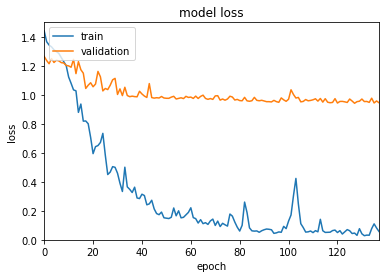

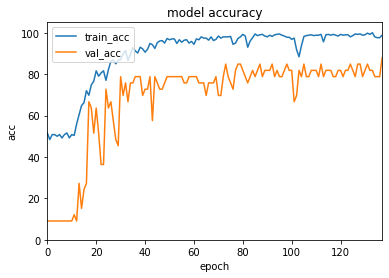

In [11]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  87.87878787878788  PPV |  [0.96428571 0.4       ]  Recall |  [0.9        0.66666667]


<AxesSubplot:>

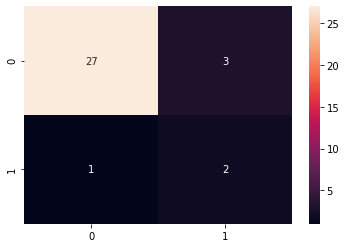

In [12]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(Y_test, y_pred_list)
ppv = precision_score(Y_test, y_pred_list, average=None)
recall = recall_score(Y_test, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(Y_test, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

In [13]:
print(classification_report(Y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93        30
         1.0       0.40      0.67      0.50         3

    accuracy                           0.88        33
   macro avg       0.68      0.78      0.72        33
weighted avg       0.91      0.88      0.89        33



In [14]:
#Save model once everything is all figured out
#Models below were initially trained at 150 epochs. Re-trained for optimizing ppv, recall, and acc, without overtraining.
'''
SMOTENC Results
10% Test - 26 04 ppv - 0.333 recall - 0.666
            1  2 
EPOCHS = 127
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

10% Test - 26 04 ppv - 0.2 recall - 0.333
            2  1 
EPOCHS = 150
BATCH_SIZE = 15
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.15
        
10% Test - 27 03 ppv - 0.4 recall - 0.666
            1  2 
EPOCHS = 138
BATCH_SIZE = 20
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20
'''

#Undersample majority class using smote
#Oversample minority class using smote
#Combine these to create a training set

#Compare SmoteTomek that does undersampling & oversampling vs two separate smotes: SMOTENC for oversampling minority class and another SMOTE for undersampling the majority class
#Shooting for over 20% ppv
#for next week: smotetomek stuff, and begin loading pre-training model for ADHD symptom prediction

'\nSMOTENC Results\n10% Test - 26 04 ppv - 0.333 recall - 0.666\n            1  2 \nEPOCHS = 127\nBATCH_SIZE = 30\nLEARNING_RATE = 0.001\nDROPOUT_RATE = 0.20\n\n10% Test - 26 04 ppv - 0.2 recall - 0.333\n            2  1 \nEPOCHS = 150\nBATCH_SIZE = 15\nLEARNING_RATE = 0.001\nDROPOUT_RATE = 0.15\n        \n10% Test - 22 08 ppv - 0.2 recall - 0.666\n            1  2 \nEPOCHS = 150\nBATCH_SIZE = 20\nLEARNING_RATE = 0.001\nDROPOUT_RATE = 0.20\n'